In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [4]:
using Revise
using AdaptiveTransportMap
using LinearAlgebra
using Test
using ForwardDiff
using SpecialFunctions
using Polynomials
using BenchmarkTools
using TransportMap
using QuadGK
using FastGaussQuadrature
using AdaptiveTransportMap: derivative, vander, scale!, evaluate
using DiffResults
using QuadGK
using Distributions
using Random
using TensorOperations

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1260


### Storage

In [12]:
Nx = 2
Ne = 8
ens = EnsembleState(Nx, Ne)

ens.S .=  [0.267333   1.43021;
          0.364979   0.607224;
         -1.23693    0.249277;
         -2.0526     0.915629;
         -0.182465   0.415874;
          0.412907   1.01672;
          1.41332   -0.918205;
          0.766647  -1.00445]';
B = MultiBasis(CstProHermite(3; scaled =true), Nx)

idx = [0 0; 0 1; 1 0; 1 1; 1 2]
truncidx = idx[1:2:end,:]
Nψ = 5

coeff =   [0.6285037650645056;
 -0.4744029092496623;
  1.1405280011620331;
 -0.7217760771894809;
  0.11855056306742319]
f = ExpandedFunction(B, idx, coeff)

ExpandedFunction{5,5,2}(MultiBasis{5,2}(Basis of 5 functions:
ProPolyHermite{0}(ImmutablePolynomial(1.0), false)
ProHermite{0}(ProPolyHermite{0}(ImmutablePolynomial(0.6316187777460647), true), true)
ProHermite{1}(ProPolyHermite{1}(ImmutablePolynomial(0.6316187777460647*x), true), true)
ProHermite{2}(ProPolyHermite{2}(ImmutablePolynomial(-0.44662192086900115 + 0.44662192086900115*x^2), true), true)
ProHermite{3}(ProPolyHermite{3}(ImmutablePolynomial(-0.7735718587191167*x + 0.25785728623970555*x^3), true), true)
), [0 0; 0 1; … ; 1 1; 1 2], [0.6285037650645056, -0.4744029092496623, 1.1405280011620331, -0.7217760771894809, 0.11855056306742319])

### Total order

Test Summary:                                                     | Pass  Total
Test evaluation, gradient and hessian of expanded function Nx = 3 | 1517   1517


Test.DefaultTestSet("Test evaluation, gradient and hessian of expanded function Nx = 3", Any[], 1517, false)

### Integration

In [39]:
function gaussint(L::Function, N::Int64, b)
    a = 0.0
    Δ = (b - a)/2
    m = (a + b)/2
    # Transform integral to [-1,1] and use gausslegendre quadrature
    
    nodes, weights = gausslegendre( N )
#     nodes, weights = gausschebyshev( N )

    out = 0.0
    @inbounds for k=1:N
        out += L(Δ*nodes[k]+m)*weights[k]
    end
    
    return Δ*out
end

gaussint (generic function with 2 methods)

In [40]:
function gaussint(L::Function, nodes, weights, b)
    a = 0.0
    Δ = (b - a)/2
    m = (a + b)/2
    N = size(nodes,1)

    out = 0.0
    @inbounds for k=1:N
        out += L(Δ*nodes[k]+m)*weights[k]
    end
    
    return Δ*out
end

gaussint (generic function with 2 methods)

In [41]:
function timing()
    recti = Rectifier("softplus")
#     @btime ApproxFun.integrate(Fun(x->g∘FamilyPhyHermite[6](x),0.0..1.0))(1.0)
#     @show  ApproxFun.integrate(Fun(x->g∘FamilyPhyHermite[6](x),0.0..1.0))(1.0)
    @show quadgk(x->recti(sum(i->FamilyPhyHermite[i](x),1:6)), 0.0,5.0)

    
    @btime quadgk(x->recti(sum(i->FamilyPhyHermite[i](x),1:6)),0.0,5.0; rtol=1e-4)
    @show quadgk(x->recti(sum(i->FamilyPhyHermite[i](x),1:6)), 0.0,5.0; rtol=1e-4)
    
        

    @btime gaussint(x->recti(sum(i->FamilyPhyHermite[i](x),1:6)), 200, 5.0)
    @show gaussint(x->recti(sum(i->FamilyPhyHermite[i](x),1:6)), 200, 5.0)
    
#     @btime nodes, weights = gausslegendre( 200 )
#     @btime begin 
#         nodes, weights = gausslegendre( 200 )
#         gaussint(x->recti(sum(i->FamilyPhyHermite[i](x),1:6)), nodes, weights, 5.0)
#     end
#     @show gaussint(x->recti(sum(i->FamilyPhyHermite[i](x),1:6)), nodes, weights, 5.0)

end

timing (generic function with 1 method)

In [37]:
recti = Rectifier("softplus")

Rectifier("softplus")

In [38]:
timing()

quadgk((x->begin
            #= In[36]:5 =#
            recti(sum((i->begin
                            #= In[36]:5 =#
                            (FamilyPhyHermite[i])(x)
                        end), 1:6))
        end), 0.0, 5.0) = (106.68643931331204, 7.848799081586882e-7)
  129.279 μs (6603 allocations: 104.16 KiB)
quadgk((x->begin
            #= In[36]:9 =#
            recti(sum((i->begin
                            #= In[36]:9 =#
                            (FamilyPhyHermite[i])(x)
                        end), 1:6))
        end), 0.0, 5.0; rtol = 0.0001) = (106.68646050875634, 0.004013476235948468)
  147.384 μs (7804 allocations: 125.44 KiB)
gaussint((x->begin
            #= In[36]:14 =#
            recti(sum((i->begin
                            #= In[36]:14 =#
                            (FamilyPhyHermite[i])(x)
                        end), 1:6))
        end), 200, 5.0) = 139.21354563131862


139.21354563131862

In [149]:
typeof(x->recti(sum(i->FamilyPhyHermite[i](x),1:6)))<:Function

true

In [134]:
quadgk(x->recti(FamilyPhyHermite[6](x)),0.0,1.0)

(22.17780901415047, 9.325757673039892e-9)

### Basis

In [30]:
Nx = 6
B = CstProHermite(7)
MB = MultiBasis(B, Nx)

MultiBasis{9,6}(Basis of 9 functions:
ProPolyHermite{0}(ImmutablePolynomial(1.0), false)
ProHermite{0}(ProPolyHermite{0}(ImmutablePolynomial(1.0), false), false)
ProHermite{1}(ProPolyHermite{1}(ImmutablePolynomial(1.0*x), false), false)
ProHermite{2}(ProPolyHermite{2}(ImmutablePolynomial(-1.0 + 1.0*x^2), false), false)
ProHermite{3}(ProPolyHermite{3}(ImmutablePolynomial(-3.0*x + 1.0*x^3), false), false)
ProHermite{4}(ProPolyHermite{4}(ImmutablePolynomial(3.0 - 6.0*x^2 + 1.0*x^4), false), false)
ProHermite{5}(ProPolyHermite{5}(ImmutablePolynomial(15.0*x - 10.0*x^3 + 1.0*x^5), false), false)
ProHermite{6}(ProPolyHermite{6}(ImmutablePolynomial(-15.0 + 45.0*x^2 - 15.0*x^4 + 1.0*x^6), false), false)
ProHermite{7}(ProPolyHermite{7}(ImmutablePolynomial(-105.0*x + 105.0*x^3 - 21.0*x^5 + 1.0*x^7), false), false)
)

In [4]:
@btime ForwardDiff.gradient(x->B[5](x[1]),[5.0])

  1.867 μs (9 allocations: 480 bytes)


1-element Array{Float64,1}:
 -0.39188218965422494

In [5]:
@btime ForwardDiff.derivative(x->B[5](x),5.0)

  107.739 ns (6 allocations: 176 bytes)


-0.39188218965422494

In [6]:
function timing()
    f(x) = (x^5-4*x^3+1)*exp(-x^2/2)  
    @btime ForwardDiff.gradient(x->f(x[1]),[5.0])
    @btime ForwardDiff.derivative(x->f(x),5.0)
end

timing (generic function with 1 method)

In [51]:
FamilyPhyHermite[5].P

PhyHermite{4}(PhyPolyHermite{4}(ImmutablePolynomial(12.0 - 48.0*x^2 + 16.0*x^4), false), false)

In [8]:
@btime quadgk(x->FamilyPhyHermite[5](x), 0, 1.0)

  2.024 μs (137 allocations: 2.34 KiB)


(0.5630021473036511, 1.4497070210950369e-11)

In [33]:
Nx = 10
Nψ = 8
B = CstProHermite(4)
MB = MultiBasis(B, Nx)
f = ExpandedFunction([MultiFunction(MB, rand(1:6,10)) for i=1:5], randn(5));

In [45]:
(f.ψ[1])(randn(10))

-1.0681201568508658

In [54]:
g!(xo, xd) = f(vcat(xo, xd))

g! (generic function with 1 method)

In [55]:
g(xo::Array{Float64,1}) = xd -> g!(xo, xd)

g (generic function with 2 methods)

In [67]:
using Plots

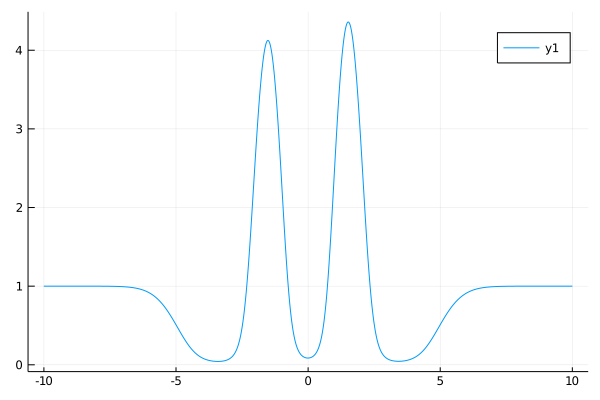

In [72]:
plot(collect(-10.0:0.01:10.0), (Rectifier("softplus") ∘g(randn(9))).(collect(-10.0:0.01:10.0)))

In [84]:
xo = randn(9);

In [86]:
@time G = cumsum(Fun(Rectifier("softplus")∘g(xo), 0..10.0))

  0.004711 seconds (145.01 k allocations: 2.526 MiB)


Fun(Chebyshev(0.0..10.0),[5.656855089037586, 4.952404627372026, -0.6269385412471704, 0.7063549702634647, -0.13627587692587023, -0.4089768642083975, 0.46697274793564175, -0.18981804948679865, -0.06605195342904858, 0.15508432388423396  …  2.7895161158483325e-17, 2.4866701439909472e-17, -4.593449467743839e-17, 2.633310236532793e-17, 8.662413597474137e-18, -2.963485938127045e-17, 2.5553745274826337e-17, -4.56730836440744e-18, -1.6713720549178502e-17, 1.2561498607781274e-17])

In [89]:
@time quadgk(Rectifier("softplus")∘g(xo), 0.0, 1.0)

  0.000318 seconds (13.02 k allocations: 227.109 KiB)


(0.7043585614440956, 5.962256660607679e-10)

In [96]:
function timing()
    xo = randn(9);
    @btime G = cumsum(Fun(Rectifier("softplus")∘g(xo), 0..1.0))
    @btime G(1.0)
    @btime quadgk(Rectifier("softplus")∘g(xo), 0.0, 1.0)
    @btime Rectifier("softplus")∘g(xo)($randn())
end 

timing (generic function with 1 method)

In [97]:
timing()

  791.964 μs (34402 allocations: 621.30 KiB)
  272.410 ns (1 allocation: 16 bytes)
  239.780 μs (13018 allocations: 227.11 KiB)
  5.305 μs (287 allocations: 5.02 KiB)


#64 (generic function with 1 method)

In [102]:

Nx = 10
Ne = 500
ens = EnsembleState(Nx, Ne)

ens.S .= randn(Nx) .+ rand(Nx) .* randn(Nx, Ne)

scale!(ens; diag = false)

@test norm(mean(ens))<1e-10
@test norm(cov(ens)  - I)<1e-10

Test Passed

In [103]:
cov(ens)

10×10 Array{Float64,2}:
  1.0          1.77992e-18   6.94168e-17  …  -1.42393e-17   7.47565e-17
  1.77992e-18  1.0           1.77992e-17      1.06795e-17   1.06795e-17
  6.94168e-17  1.77992e-17   1.0             -5.33975e-18  -4.2718e-17
  1.77992e-17  7.11967e-18  -7.11967e-18     -2.2249e-17   -1.77992e-17
 -7.11967e-18  2.1359e-17   -1.06795e-17      3.02586e-17   5.33975e-18
  7.11967e-17  2.84787e-17   1.06795e-17  …   2.84787e-17   2.49188e-17
 -1.06795e-17  6.4077e-17    4.98377e-17     -7.11967e-18   9.96753e-17
  2.31389e-17  3.55983e-17   1.24594e-17      9.25557e-17  -4.96152e-17
 -1.42393e-17  1.06795e-17  -5.33975e-18      1.0           8.89958e-18
  7.47565e-17  1.06795e-17  -4.2718e-17       8.89958e-18   1.0

In [66]:
Rectifier("softplus")(5.0)

5.044394119358453

In [64]:
@btime G(1.0)

  2.367 ms (1 allocation: 16 bytes)


3.4917120649508404

In [10]:
result = DiffResults.HessianResult(randn(10));
@time result = ForwardDiff.gradient!(result, f, randn(10));

MethodError: MethodError: no method matching getindex(::MultiBasis{6,10}, ::Int64)

In [11]:
first()

MethodError: MethodError: no method matching first()
Closest candidates are:
  first(!Matched::Tuple{}) at tuple.jl:95
  first(!Matched::BitSet) at bitset.jl:356
  first(!Matched::Core.Compiler.StmtRange) at show.jl:1848
  ...

In [12]:
function timing2()
    @btime x = randn(100,20)
    @btime begin 
        x = randn(20,200)
        for i=1:200
        x[10,i]
        end
    end
end

timing2 (generic function with 1 method)

In [13]:
timing2()

  10.325 μs (1 allocation: 15.75 KiB)
  20.985 μs (2 allocations: 31.33 KiB)


In [14]:
function timing()
    Nx = 10
    Nψ = 8
    B = CstProHermite(4)
    MB = MultiBasis(B, Nx);
    f = ExpandedFunction([MultiFunction(MB, rand(1:6,10)) for i=1:5], randn(5));
    [f(randn(10)) for i=1:200]
end

timing (generic function with 1 method)

In [15]:
@btime timing()

MethodError: MethodError: no method matching getindex(::MultiBasis{6,10}, ::Int64)

In [16]:
@time [f(randn(10)) for i=1:200]

MethodError: MethodError: no method matching getindex(::MultiBasis{6,10}, ::Int64)

In [18]:
function timing() 
    f = MultiFunction(MB, rand(1:6,10));
    result = DiffResults.HessianResult(randn(10));
    result = ForwardDiff.hessian!(result, f, randn(10));
end

timing (generic function with 1 method)

In [19]:
function timing2() 
    f = MultiFunction(MB, rand(1:6,10));
    x = randn(10)
    f(x)
    ForwardDiff.gradient(f, x);
    ForwardDiff.hessian(f, x);
end

timing2 (generic function with 1 method)

### Hermite functions

In [68]:
FamilyScaledPhyHermite[5]

PhyHermite{4}(PhyPolyHermite{4}(ImmutablePolynomial(0.4599685791773267 - 1.8398743167093068*x^2 + 0.6132914389031022*x^4), true), true)

In [61]:
integral, err = quadgk(x-> (12.0 -48*x^2 + 16*x^4)*exp(-x^2/2), 0.0, 1.0, rtol=1e-12)

(0.5630021473036511, 8.881784197001252e-16)

In [103]:
function integrate(f,a,b)
    return quadgk(x-> f(x), a, b, rtol=1e-12)[1]
end

integrate (generic function with 1 method)

In [107]:
function timing()
    @btime integrate(FamilyScaledPhyHermite[7], 0, 2.0)
    @btime derivative(FamilyScaledPhyHermite[7], -1, [2.0])
end

timing (generic function with 1 method)

In [108]:
timing()

  10.976 μs (848 allocations: 13.86 KiB)
  3.005 μs (108 allocations: 3.39 KiB)


1-element Array{Float64,1}:
 -0.08868073032617163